See page 19 of Deep Learning for Time Series Forecasting
### Define problem
1. Input: some rows of the orderbook.
2. Output: a single price (estimate for bid1 in a few seconds), or a binary label (1 if the model expects bid1 to rise by 25 basis points)
3. All variables are endogeneous
4. All variables are structured (clear time-dependent pattern, i.e. trend)
5. Multivariate time series problem
6. We're forecasting a single step, but this isn't the next step. Maybe it makes more sense to do multi-step forecasting, i.e. forecast all values between the target and the current value.
7. Dynamically updated model
8. Observations are practically contiguous (average of 1 second gap between rows, with very little deviation), i.e. uniform over time

### Design test harness
1. Dataset has already been split. 1 day for training, 1 day for testing.
2. I've implemented a candidate approach; vanilla LSTM for the regression problem.
3. I've made predictions on the test set directly, need to try walk-forward validation.
4. The metric that compares predictions to expected values has been defined in the function evaluate_regression_model().

### Test models
1. Simple forecasting such as persistence and averages
2. Autoregression: the Box_Jenkins process and methods such as SARIMA
3. Exponential Smoothing: Single, double and triple exponential smoothing methods.
4. Linear Machine Learning: lin reg and variants such as regularization
5. Nonlinear Machine Learning: kNN, decision trees, support vector regression and more.
6. Ensemble Machine Learning: Random forest, gradient boosting, stacking and more. 
7. Deep Learning: MLP, CNN, LSTM, Hybrid models.

Ideally, exhaust each level before moving on to the next. The skill of the model in the next level should outperform the model in the current level, otherwise there's something wrong with your approach. 

Data preparation schemes to consider: differencing to remove a trend, seasonal differencing to remove seasonality, standardise to centre, normalise to rescale, power transform to make normal. 



### Notes:
In the entire test data, there are 21 instances of the price rising 0.25% (25 basis points) or more in a span of 5 seconds. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

In [2]:
ob_train = pd.read_csv('/Users/Sanjit/Repos/Predictive Analytics/train_orderbook.csv') #train orderbook
tb_train = pd.read_csv('/Users/Sanjit/Repos/Predictive Analytics/train_trades.csv')#train tradebook

ob_test = pd.read_csv('/Users/Sanjit/Repos/Predictive Analytics/test_orderbook.csv') #test orderbook 
tb_test = pd.read_csv('/Users/Sanjit/Repos/Predictive Analytics/test_trades.csv')#test tradebook

In [96]:
ob_train = ob_train.head(15)
ob_test = ob_test.head(15)

## Preliminary data exploration

In [4]:
#time difference in seconds between consecutive rows of orderbook
time_difference = np.diff(pd.to_datetime(ob_train['timestamp']).astype('int').to_numpy())/(1000000000)

print("Mean: ", np.mean(time_difference), "\nStandard deviation: ", np.std(time_difference))
print("Max: ", np.max(time_difference))

Mean:  1.007023328983589 
Standard deviation:  1.3061452462652685
Max:  381.767076


In [4]:
horizon = 30
df1 = ob_train.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1']).pct_change(horizon)[horizon:]
#Rows of train where the price increase in horizon seconds was 0.25% or more
df1 = df1[df1['bid1'] >= 0.0025]
print(len(df1))

238


In [5]:
df2 = ob_test.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1']).pct_change(horizon)[horizon:]
#Rows of train where the price increase in horizon seconds was 0.25% or more
df2 = df2[df2['bid1'] >= 0.0025]
print(len(df2))

383


In [17]:
#Is there anything special about the 5 row blocks preceding each of the rows in df1 and df2?

## Feature Engineering

In [3]:
#Source: https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
#Standardise prices and quantities. Normalisation is not suitable, since the time series may trend up or down.
#Assumes that observations fit a Gaussian distribution. Can plot to check this
#Standardization requires that you know or are able to accurately estimate the mean and standard deviation of observable values
def standardise(df):
    scalers = [] #save the scalers so we can inverse_transform later
    for column in df.columns:
        if column not in ['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1']:
            x = np.array(df[column])
            scaler = StandardScaler()
            scaler.fit(x.reshape(len(x), 1))
            df[column] = scaler.transform(x.reshape(len(x), 1))
            scalers.append(scaler)
    return df, scalers

In [4]:
ob_train, train_scalers = standardise(ob_train)

## Building dataset

Our 'X' data will be the previous **window_length** rows (including the current one) of the the feature set. The 'y' data will be bid1 in the **horizon**th row below the last row of the 'X' data. 

Alternatively, we can code 'y' data as a binary variable: 1 if bid1 in the next row is 25 basis points more than bid1 in the current row, and 0 if not.

In [5]:
#Source: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
#Drop irrelevant columns
#Reshape data into the shape (batch_size, window_length, features), where batch_size is the maximum possible batch size. 
#The shape of one single sample with window_length=5 and features=40 is (1, 5, 40)

'''
raw: 10, 20, 30, 40, 50, 60

X				y
10, 20, 30		40
20, 30, 40		50
30, 40, 50		60
'''

def build_ds_regression(raw, window_length, horizon):
    raw = raw.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1'])
    ds = raw.to_numpy()
    X = []
    y = []
    for i in range(len(ds) - window_length - horizon):
        X_instance, y_instance = ds[i:i+window_length, :], ds[i+window_length+horizon, 0]
        X.append(X_instance)
        y.append(y_instance)
    X = np.array(X)
    y = np.array(y) 
    return X, y

def build_ds_classification(raw, window_length, horizon, threshold):
    raw = raw.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1'])
    ds = raw.to_numpy()
    X = []
    y = []
    for i in range(len(ds) - window_length - horizon):
        X_instance = ds[i:i+window_length, :]

        bid_now = ds[i+window_length-1, 0] #the most recent bid1 at the time the prediction is made
        target = ds[i+window_length+horizon, 0] #bid1, horizon time steps (seconds) ahead
        pct_change = (target-bid_now)/bid_now
        y_instance = 1 if pct_change > threshold else 0

        X.append(X_instance)
        y.append(y_instance)
    X = np.array(X)
    y = np.array(y) 
    return X, y

In [6]:
#Use with regression models

#aka time_steps in existing literature. Each prediction is based on window_length rows.
window_length = 15
#predict (horizon+1) seconds ahead (on average).
horizon = 30 #Increasing this massively increases no. of training epochs required. Increasing learning rate solves this.

X_train, y_train = build_ds_regression(ob_train, window_length, horizon)
print(X_train.shape, y_train.shape)

(85325, 15, 40) (85325,)


In [22]:
#Use with classification models

#aka time_steps in existing literature. Each prediction is based on window_length rows.
window_length = 15
#predict (horizon+1) seconds ahead (on average).
#Increasing this massively increases no. of training epochs required. Increasing learning rate solves this.
horizon = 30
#An increase of 25 basis points means a rise by 0.25% –> threshold should be 0.25.
threshold = 0.25

X_train, y_train = build_ds_classification(ob_train, window_length, horizon, threshold)
print(X_train.shape, y_train.shape)

(991, 5, 40) (991,)


## Model Training


In [7]:
def build_regression_model(learning_rate=0.001, window_length=window_length, features=X_train.shape[2]):
    model = keras.Sequential()
    model.add(layers.LSTM(50, activation='relu', input_shape=(window_length, features)))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='linear')) #We want the model to output a single number, it's prediction of bid1
    #model.add(layers.Activation('linear'))

    #For some reason, model training works even when we set layer size to 2. However, predictions will be vectors of size 2. 

    #Compile model
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer = opt) 
    return model

In [59]:
#The dataset is highly imbalanced, in that there are many more zeroes than ones in y_train. How to deal with this?

def build_classification_model(learning_rate=0.001, window_length=window_length, features=X_train.shape[2]):
    model = keras.Sequential()
    model.add(layers.LSTM(50, activation='relu', input_shape=(window_length, features)))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid')) #We want the model to output a single number, it's prediction of bid1
    #model.add(layers.Activation('sigmoid'))
    #Compile model
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer = opt, metrics=['accuracy']) 
    return model

In [ ]:
'''
# split data
data = ...
train, validation, test = split(data)
 
# tune model hyperparameters
parameters = ...
for params in parameters:
	model = fit(train, params)
	skill = evaluate(model, validation) 

# evaluate final model for comparison with other models
model = fit(train)
skill = evaluate(model, test)
'''

#Customise the training process
def train_model()
    pass

In [8]:
model = build_regression_model()
#model = build_classification_model()

In [10]:
# Create a callback that saves the model's weights
checkpoint_path = "/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/window_15_horizon_30_lr_0.001_regression.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [10]:
#To save model weights, execute bottom line only
#model.fit(X_train, y_train, epochs = 100, shuffle=False, verbose=1) 
model.fit(X_train, y_train, epochs = 100, validation_split = 0.05, callbacks=[cp_callback], shuffle=False, verbose=1)

Epoch 1/100
2534/2534 [==============================] - 24s 9ms/step - loss: 0.0554 - val_loss: 0.0066

Epoch 00001: saving model to /Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/window_15_horizon_30_lr_0.001_regression.ckpt
Epoch 2/100
2534/2534 [==============================] - 22s 9ms/step - loss: 0.0190 - val_loss: 0.0102

Epoch 00002: saving model to /Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/window_15_horizon_30_lr_0.001_regression.ckpt
Epoch 3/100
2534/2534 [==============================] - 22s 9ms/step - loss: 0.0048 - val_loss: 0.0122

Epoch 00003: saving model to /Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/window_15_horizon_30_lr_0.001_regression.ckpt
Epoch 4/100
2534/2534 [==============================] - 25s 10ms/step - loss: 0.0088 - val_loss: 0.0156

Epoch 00004: saving model to /Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/window_15_horizon_30_lr_0.001_regression.ckpt
Epoch 5/100
2534/2534 [====================

Sample output:

Epoch 1/2

2668/2668 

This means that there were 2668 batches processed in ths epoch

## Model Evaluation

In [11]:
ob_test, test_scalers = standardise(ob_test)

In [12]:
X_test, y_test = build_ds_regression(ob_test, window_length, horizon)
#X_test, y_test = build_ds_classification(ob_test, window_length, horizon, threshold)

In [13]:
# Load saved weights
#checkpoint_path = "/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/window_15_horizon_30_lr_0.001_regression.ckpt"
model.load_weights(checkpoint_path) #All we have to do before this line is to define and compile the model
results = model.evaluate(X_test, y_test, verbose=1)
print("test loss:", results)

2634/2634 [==============================] - 8s 3ms/step - loss: 0.0715
test loss: 0.062410205602645874


In [14]:
#predictions = model.predict(X[(len(X)-1):]) #Predict using the last sample in the training data
predictions = model.predict(X_test)
print("predictions shape:", predictions.shape) #Model prediction of the 50 next prices
#de-standardise the data, i.e. return to original scale. test_scalers[0] is the scaler for the column bid1. Use with regression only
predictions = test_scalers[0].inverse_transform(predictions.reshape(len(predictions), 1))

predictions shape: (84268, 1)


In [15]:
def evaluate_regression_model(ob_test):
    #For use with regression model
    df_eval = ob_test[['timestamp', 'bid1']].rename(columns={"bid1": "observed"})[window_length+horizon:].reset_index(drop=True)

    observed = np.array(df_eval['observed'])
    observed = observed.reshape(len(observed), 1)
    observed = test_scalers[0].inverse_transform(observed) #de-standardise
    df_eval['observed'] = observed 

    #The model thinks this series contains the values of bid1 at the corresponding timestamps
    #predictions has already been de-standardised above
    df_eval['predicted'] = predictions 

    #price when prediction made, corresponding timestamp in df_eval is different to timestamp when prediction was actually made.
    pwpm = np.array(ob_test['bid1'][window_length-1:len(ob_test)-horizon-1])
    pwpm = pwpm.reshape(len(pwpm), 1)
    pwpm = test_scalers[0].inverse_transform(pwpm) #de-standardise
    df_eval['pwpm'] = pwpm

    ai = observed - pwpm #actual increase
    df_eval['act_inc'] = ai

    pi = predictions - pwpm #predicted increase
    df_eval['pred_inc'] = pi

    api = (ai.reshape(len(ai), 1)/pwpm) #actual percentage increase in decimal
    df_eval['act_pct_inc'] = api

    ppi = (pi.reshape(len(pi), 1)/pwpm) #predicted percentage increase in decimal
    df_eval['pred_pct_inc'] = ppi

    #An increase of 25 basis points is equivalent to an increase of 0.25%. 
    threshold = 0.0025

    #Accuracy = number of correct predictions / total number of predictions
    n_true_positives = len(df_eval[(df_eval['act_pct_inc'] >= threshold) & (df_eval['pred_pct_inc'] >= threshold)])
    n_predictions = len(df_eval[df_eval['pred_pct_inc'] >= threshold])
    print("Correct predictions: ", n_true_positives, "||", "Total predictions: ", n_predictions, "\n")

    if n_predictions > 0:
        accuracy = n_true_positives / n_predictions
        print("Accuracy: ", accuracy, "\n")
    else:
        print("No positive predictions made", "\n")

    #Model predicts price won't rise by 25bp, so we don't trade, but the price does rise by 25bp
    n_missed_opportunities = len(df_eval[(df_eval['act_pct_inc'] >= threshold) & (df_eval['pred_pct_inc'] < threshold)])
    n_opportunities = len(df_eval[df_eval['act_pct_inc'] >= threshold])
    print("Missed opportunities: ", n_missed_opportunities, "||", "Total opportunities: ", n_opportunities, "\n")

    #Compute other metrics
    mse = np.power((predictions - observed), 2).sum(axis=0) / len(predictions)
    mae = np.abs(predictions - observed).sum(axis=0)/len(predictions)
    rmse = np.sqrt(mse)

    ybar = np.tile(observed.sum(axis=0)/len(observed), (len(observed), 1))
    tss = np.power(observed - ybar, 2).sum(axis=0)
    r2 = 1 - (len(predictions)*mse / tss)

    print("MSE: ", mse)
    print("MAE: ", mae)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)

    return df_eval

In [16]:
df_eval = evaluate_regression_model(ob_test)

Correct predictions:  86 || Total predictions:  16781 

Accuracy:  0.005124843573088612 

Missed opportunities:  315 || Total opportunities:  401 

MSE:  [18545.50296841]
MAE:  [106.34545889]
RMSE:  [136.1818746]
R-squared:  [0.93757649]


Text(0.5, 1.0, 'Red: Real     Green: Predicted')

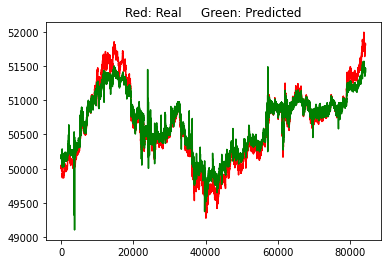

In [17]:
plt.plot(df_eval.index.values, df_eval['observed'], color='red')
plt.plot(df_eval.index.values, df_eval['predicted'], color='green')
plt.title("Red: Real     Green: Predicted")

## Next steps to be implemented in Attempt2

* Probably need a much larger lstm layer when training on the full training set, since there are already 40-ish features. 


* Result for model with checkpoint_path = "/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/window_15_horizon_30_lr_0.001_regression.ckpt": (was only trained for 25 epochs) 

Correct predictions:  86 || Total predictions:  16781 

Accuracy:  0.005124843573088612 

Missed opportunities:  315 || Total opportunities:  401 

MSE:  [18545.50296841]
MAE:  [106.34545889]
RMSE:  [136.1818746]
R-squared:  [0.93757649]

* Probably need to include all values between now and the horizonth value in the future in y_train.
* Bottom-line: need to replicate performance of CollectiWise model. 


* How to use tradebook data? Maybe can create a pseudo-volatility feature which is high when there are many large volume trades placed recently, and is low otherwise.


* Classification model: the dataset is highly imbalanced, in that there are many more zeroes than ones in y_train. How to deal with this? Right now the model just predicts zero for everything.
* Consider opportunities to short sell as well, not just increases of 25bp but also decreases.